## Homework

Getting the data for the homework

In [66]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

Loading and exploring the data

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from IPython.display import display

In [68]:
df = pd.read_csv('AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [69]:
df.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [70]:
y = (df['card'] == 'yes').astype(int).to_numpy()
del df['card']
y

array([1, 1, 1, ..., 1, 1, 1])

Split the dataset into 3 parts: train/validation/test with $60\%/20\%/20\%$ distribution.

In [71]:
from sklearn.model_selection import train_test_split

df_full_train, df_test, y_full_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)

df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=1)


### Question 1

In [72]:
from sklearn.metrics import roc_auc_score

In [73]:
numerical_columns = df.columns[df.dtypes != 'object'].to_list()
numerical_columns

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [74]:
roc_auc_scores_df = pd.DataFrame([], index=numerical_columns, columns=['auc'])
for column in numerical_columns:
    auc = roc_auc_score(y_train, df_train[column].to_numpy())
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[column].to_numpy())
    roc_auc_scores_df.loc[column, 'auc'] = auc
roc_auc_scores_df.sort_values(by='auc', axis=0)

,auc
age,0.524002
months,0.529422
dependents,0.532776
majorcards,0.534386
income,0.590805
active,0.604317
reports,0.716663
share,0.989184
expenditure,0.991042


### Question 2

Extracting `X_train` matrix applying one-hot-encoder using `DictVectorizer`

In [75]:
from sklearn.feature_extraction import DictVectorizer

columns_to_use = ["reports", "age", "income", "share", 
    "expenditure", "dependents", "months", "majorcards", 
    "active", "owner", "selfemp"]

df_train = df_train[columns_to_use]
df_val = df_val[columns_to_use]
df_test = df_test[columns_to_use]

dv = DictVectorizer()
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

Training the model

In [76]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

regressor.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [77]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = regressor.predict_proba(X_val)
y_pred

roc_auc_score(y_val, y_pred[:,1])

0.995171242063847

### Question 3 and 4

In [112]:
from tqdm.auto import tqdm
step = 0.01
thresholds = np.arange(0, 1+step, step)
precision = np.zeros(thresholds.size)
recall = np.zeros(thresholds.size)

max_f1 = -1
max_f1_t = -1
for i in tqdm(range(thresholds.size)):
    t = thresholds[i]
    y_class = (y_pred[:, 1] >= t).astype(int)
    sum_y = y_class + y_val
    diff_y = y_class - y_val
    tp = (sum_y == 2).sum()
    tn = (sum_y == 0).sum()
    fp = (diff_y == 1).sum()
    fn = (diff_y == -1).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    precision[i] = p
    recall[i] = r
    f1 = 2*p*r / (p+r)
    if f1 > max_f1:
        max_f1 = f1
        max_f1_t = t
    if p == r:
        print('p == r in ', t)

print(f'Maximum f1:{max_f1} reached at threshold: {max_f1_t}')

  0%|          | 0/101 [00:00<?, ?it/s]

p == r in  0.24
p == r in  0.25
p == r in  0.26
p == r in  0.27
p == r in  0.28
p == r in  0.29
Maximum f1:0.9832134292565947 reached at threshold: 0.35000000000000003


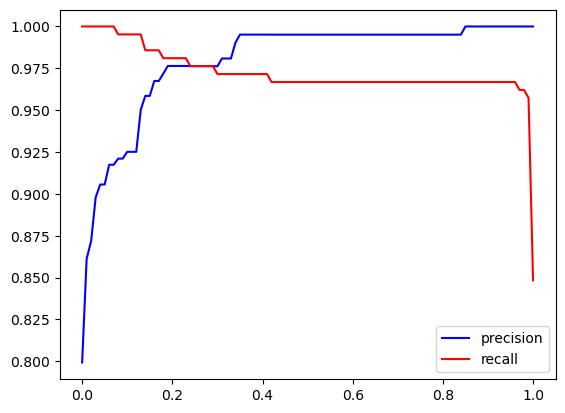

In [106]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precision, label='precision', color='blue')
plt.plot(thresholds, recall, label='recall', color='red')
plt.legend()

In [113]:
print('Question 3: 0.3')
print(f'Question 4: max_F1={max_f1} reached at threshold {max_f1_t}')

Question 3: 0.3
Question 4: max_F1=0.9832134292565947 reached at threshold 0.35000000000000003


### Question 5

In [118]:
from sklearn.model_selection import KFold
k=5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

def get_matrix(df: pd.DataFrame):
    df = df[columns_to_use]
    dv = DictVectorizer()
    X_dict = df.to_dict('records')
    return dv.fit_transform(X_dict)

roc_auc_score_list = np.zeros(k)
i=0
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]
    
    X_train = get_matrix(df_train)
    
    regressor = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    regressor.fit(X_train, y_train)
    X_val = get_matrix(df_val)
    y_pred = regressor.predict_proba(X_val)
    roc_auc_score_list[i] = roc_auc_score(y_val, y_pred[:, 1])
    i += 1
np.std(roc_auc_score_list)



0.0027434713804377724

### Question 6

In [120]:
for C in [0.01, 0.1, 1, 10]:
    roc_auc_score_list = np.zeros(k)
    i=0
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]
        
        X_train = get_matrix(df_train)
        
        regressor = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        regressor.fit(X_train, y_train)
        X_val = get_matrix(df_val)
        y_pred = regressor.predict_proba(X_val)
        roc_auc_score_list[i] = roc_auc_score(y_val, y_pred[:, 1])
        i += 1
    print(f'C={C} STD={np.round(roc_auc_score_list.std(), 3)} MEAN={np.round(roc_auc_score_list.mean(), 3)}')

C=0.01 STD=0.006 MEAN=0.992
C=0.1 STD=0.004 MEAN=0.995
C=1 STD=0.003 MEAN=0.996
C=10 STD=0.003 MEAN=0.996
